In [220]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Resultado Fiscal - último mes reportado 2019

## Resumen ejecutivo

In [221]:
#EL TEXTO PARA ARMAR DE FORMA AUTOMÁTICA- ** ver si dejarlo en formáto de código o armarlo en Markdown, en éste último caso, 
#BUSCAR!!**
print("Durante el mes de julio el Sector Público Nacional tuvo un superávit primario de $ 4.293 millones, lo que implica una mejora de $ 18.572 millones frente al déficit de $ 14.280 millones registrado en igual mes de 2018. Los recursos totales crecieron 61,6% en términos interanuales (i.a.), 11 puntos porcentuales (p.p.) más en relación a los gastos primarios que tuvieron un incremento de 50,5% i.a.")

Durante el mes de julio el Sector Público Nacional tuvo un superávit primario de $ 4.293 millones, lo que implica una mejora de $ 18.572 millones frente al déficit de $ 14.280 millones registrado en igual mes de 2018. Los recursos totales crecieron 61,6% en términos interanuales (i.a.), 11 puntos porcentuales (p.p.) más en relación a los gastos primarios que tuvieron un incremento de 50,5% i.a.


### Ingresos Totales (Formato IMIG)

In [222]:
# Armo los dataframes con los ids de los componentes de cada uno de los subtotales "tributarios", "rentas", "otros corrientes" y "capital"
 
it_tributarios= pd.read_csv("https://apis.datos.gob.ar/series/api/series/?ids=452.2_IVA_NETO_RROS_0_T_19_67,452.2_GANANCIASIAS_0_T_9_51,452.2_APORTES_COIAL_0_T_39_29,452.2_DEBITOS_CRTOS_0_T_16_22,452.2_BIENES_PERLES_0_T_17_26,452.2_IMPUESTOS_NOS_0_T_18_87,452.2_COMBUSTIBLLES_0_T_12_97,452.2_DERECHOS_EION_0_T_20_42,452.2_DERECHOS_IION_0_T_20_60,452.2_RESTO_TRIBIOS_0_T_17_0&limit=5000&format=csv")
it_rentas= pd.read_csv("https://apis.datos.gob.ar/series/api/series/?ids=452.2_FGS_COBRADERO_0_T_53_90,452.2_RESTO_RENTDAD_0_T_22_24&limit=5000&format=csv")
it_otros= pd.read_csv("https://apis.datos.gob.ar/series/api/series/?ids=452.2_INGRESOS_NIOS_0_T_23_2,452.2_TRANSFERENTES_0_T_25_22,452.2_RESTO_INGRTES_0_T_25_96&limit=5000&format=csv")
it_capital= pd.read_csv("https://apis.datos.gob.ar/series/api/series/?ids=452.2_INGRESOS_CTAL_0_T_16_75&limit=5000&format=csv")

# Transformo a formato de datetime y pongo como índice al campo "indice_tiempo"
it_tributarios.indice_tiempo= pd.to_datetime(it_tributarios.indice_tiempo)
it_rentas.indice_tiempo= pd.to_datetime(it_rentas.indice_tiempo)
it_otros.indice_tiempo= pd.to_datetime(it_otros.indice_tiempo)
it_capital.indice_tiempo= pd.to_datetime(it_capital.indice_tiempo)

it_tributarios= it_tributarios.set_index("indice_tiempo")
it_rentas= it_rentas.set_index("indice_tiempo")
it_otros= it_otros.set_index("indice_tiempo")
it_capital= it_capital.set_index("indice_tiempo")



In [223]:
#Como no contamos con los subtotales de Tributarios, Rentas, Otros Corrientes y capital para el armado del Resumen del mes IMIG,
#lo armamos trasponiendo los dataframe y sumando todos sus compoonentes. Esto nos va a permitir tener las series deseadas 
#y formar un dataframe con una estructura similar a la que queríamos llegar.

# it_tributarios.T.sum(), 
# it_rentas.T.sum(),
# it_otros.T.sum(),
# it_capital.T.sum(),
total=it_tributarios.T.sum() + it_rentas.T.sum() + it_otros.T.sum() + it_capital.T.sum()

# creamos un dataframe para Ingresos Totales con todos sus componentes. #VER COMO REORDENAR LAS FILAS!!!
ingresos_totales = pd.DataFrame({
    "tributarios": it_tributarios.T.sum(), 
    "rentas": it_rentas.T.sum(),
    "otros_corrientes": it_otros.T.sum(),
    "capital": it_capital.T.sum(),
    "Total_Ingresos_Totales":total
})

ingresos_totales.index=ingresos_totales.index.to_period()

imig_it=ingresos_totales[(ingresos_totales.index=="20180701")|(ingresos_totales.index=="20190701")].pivot_table(columns="indice_tiempo")

imig_it["var%_anual"]= round( (imig_it["2019-07"] / imig_it["2018-07"]) - 1, 4) * 100

# Quisiera agregar la diferencia absoluta en $
# PORQUE NO ME SIRVE ÉSTA ASIGNACIÓN?? imig_it["var$_anual"]= imig_it["2019-07"] - imig_it["2018-07"]

imig_it= imig_it.rename(columns={"indice_tiempo": "Concepto"})
imig_it

# FALTARÍA ORDENAR LOS CONCEPTOS POR COMPONENTE (EL "TOTAL_INGRESOS_TOTALES DEBERÍA IR AL FINAL" y si es posible remarcar en negrita)

indice_tiempo,2018-07,2019-07,var%_anual
Total_Ingresos_Totales,232618.9,375866.6,61.58
capital,4931.0,12392.5,151.32
otros_corrientes,7511.2,21290.9,183.46
rentas,14605.1,27241.4,86.52
tributarios,205571.6,314941.8,53.20


## Resultado Primario en términos del PBI



In [239]:
pbi_rp=pd.read_csv("https://apis.datos.gob.ar/series/api/series/?ids=9.2_PPC_2004_T_22,452.3_RESULTADO_RIO_0_M_18_54&collapse=quarter&collapse_aggregation=sum&limit=5000&format=csv")
pbi_rp["indice_tiempo"] = pd.to_datetime(pbi_rp["indice_tiempo"])
pbi_rp=pbi_rp.set_index("indice_tiempo")

pbi_rp= pbi_rp[pbi_rp.index>="20160101"]

#como no tenemos info del pbi estimado para el 2do trim 2019, repetimos el del 
# último trim informado

pbi_rp.loc["2019-04-01", "pib_precios_corrientes"]= pbi_rp.loc["2019-01-01", "pib_precios_corrientes"]


In [246]:
rp_imig["rp_en%_pbi"]= round((pbi_rp["resultado_primario"] / pbi_rp["pib_precios_corrientes"]) *100,4)
rp_imig = rp_imig.reset_index()
rp_imig= rp_imig.set_index("indice_tiempo")

rp_imig["meta"]=0

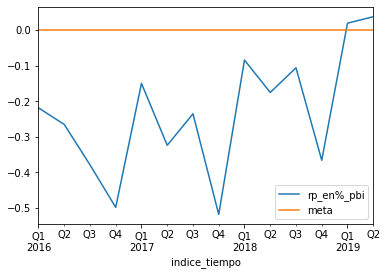

In [247]:
rp_imig.plot()

In [226]:
# trim= {1:"1T", 2:"1T", 3:"1T", 4:"2T", 5:"2T", 6:"2T", 7:"3T", 8:"3T", 9:"3T", 10:"4T", 11:"4T", 12:"4T"}
# RP["indice_tiempo"] = pd.to_datetime(RP["indice_tiempo"])
# mes = RP["indice_tiempo"].dt.month
# RP["trim"]= mes.apply(lambda x: trim[x])
# RP["trim_anio"]= RP["indice_tiempo"].dt.year.astype(str) + "-" + RP["trim"].astype(str)
# del RP["trim"]

# rp["anio_trim"]= rp.index.year.astype(str) + "-" + rp.index.quarter.astype(str)
# rp.head()



In [153]:
#plt.plot(RP.anio_trim, RP.resultado_primario, title="Resultado Primario - por trimestre")
#plt.xlabel("trimestre")
#plt.ylabel("resultado primario")

In [154]:
rp.groupby("anio_trim").sum()

KeyError: 'anio_trim'